# Import des librairies

In [1]:
local_path = 'dataset/car_data//car_data'
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
# importing pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import time
import os
import PIL.Image as Image
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA GeForce RTX 3060 Laptop GPU


# Récupération des données et définition du dataset

## Création d'un dictionnaire de classes et contage du nombre d'image par classe

In [2]:
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count

## Affichage de la distribution des classes

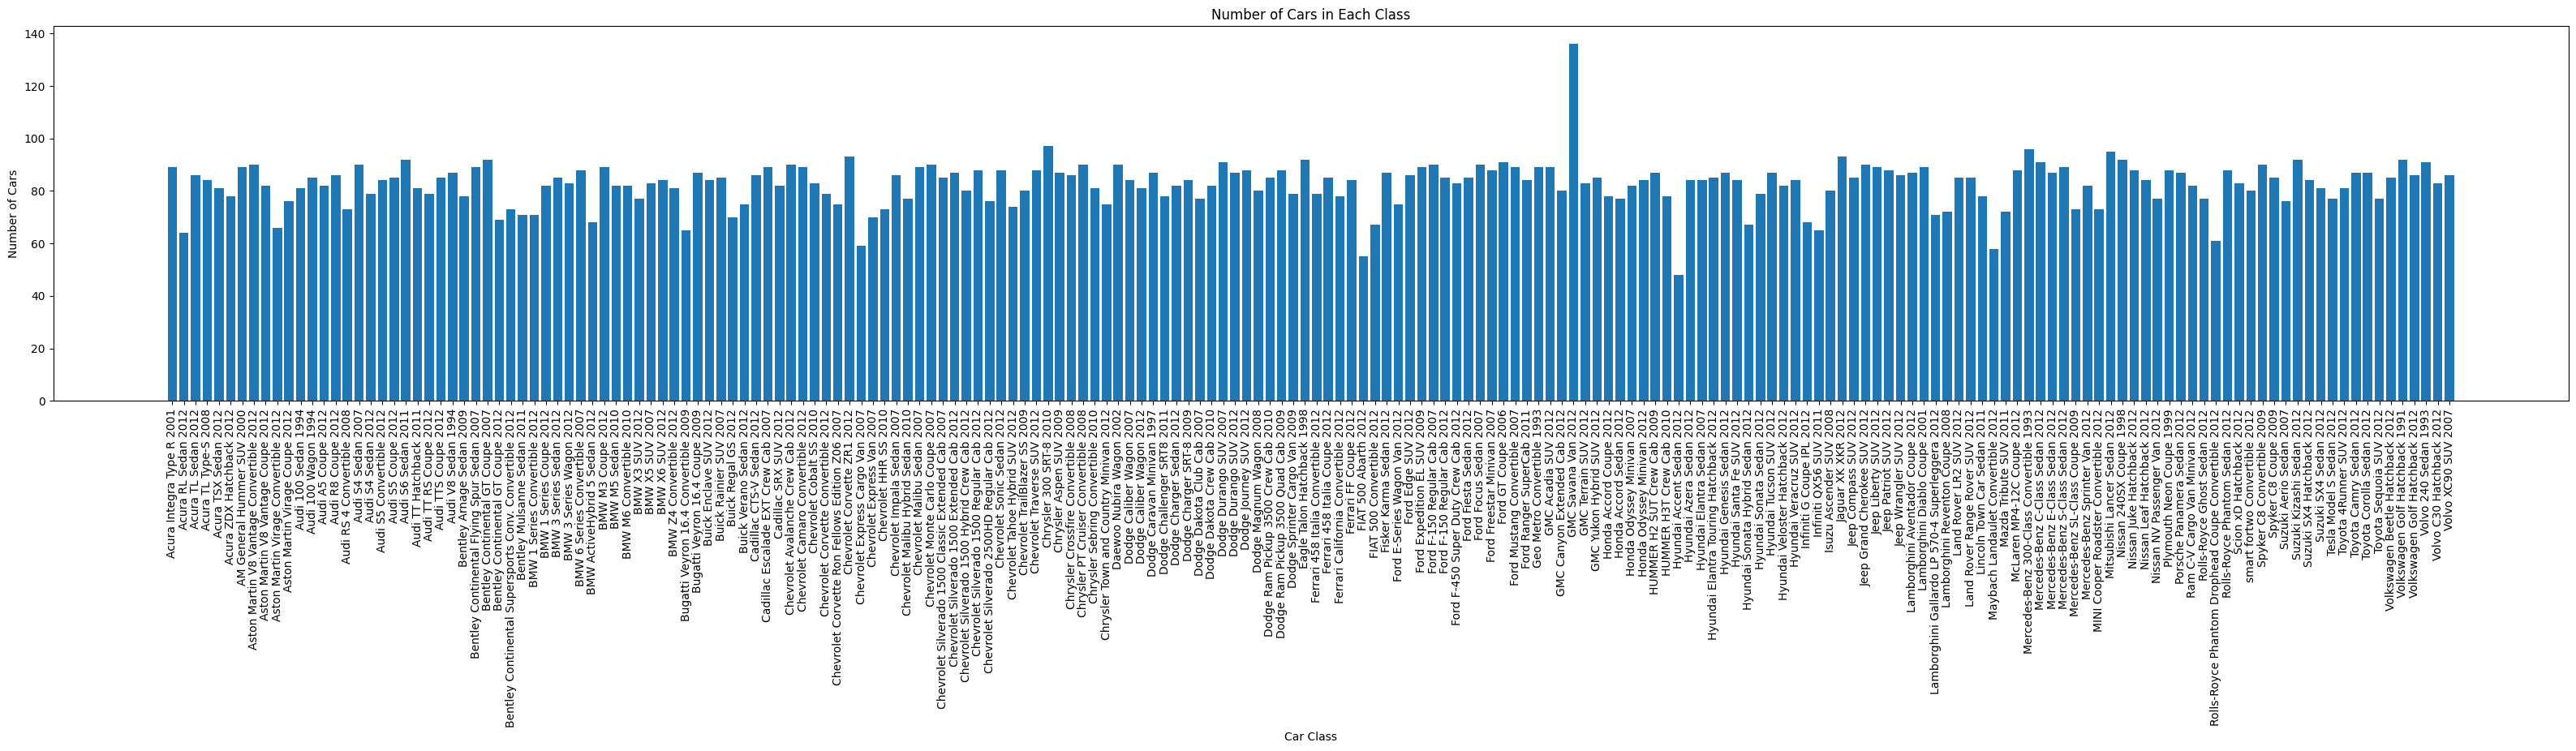

In [3]:
plt.figure(figsize=(40, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())
plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')
plt.xticks(rotation=90)
plt.show()

## Définition des transormations à appliquer sur les images

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_time_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Définiton du dataset

In [4]:
dataset_dir = local_path
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

## Récupération du modèle et affichage de son architecture

In [5]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
# getting the number of classes in the dataset
no_classes = len(train_dataset.classes)
# showing the architecture of the model
model.parameters

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\marti/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [01:02<00:00, 1.40MB/s]


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## Mise à jour du modèle pour l'adapter à nos besoins (changement de la shape d'input)

In [6]:
# replace the last fc layer with an untrained one based on the number of classes we have in our dataset (requires grad by default)
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

"""
Here we will use learning rate schedular to change the learning rate while training our model. We are tracking the training accuracy
and measuring whether it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the learning by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [7]:
import torch
from tqdm import tqdm

def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        # Iterate over the test data and generate predictions.
        for i, data in enumerate(test_loader, 0):
            # Get inputs
            images, labels = data
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)
            # If test time augmentation is provided, apply transformations
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    # Apply the transformation num_augmentations times
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    # Stack the augmented images into a single tensor and add to the list
                    augmented_images.extend(augmented_imgs)
                # Convert the list of augmented images to a single tensor
                images = torch.stack(augmented_images)

            # Forward pass
            outputs = model(images)
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels in the test data set
            total += labels.size(0) * num_augmentations
            # Total correct predictions
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calculate the accuracy
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

## Définition de comment train le modèle

In [8]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    # keeping track of losses and the accuracies
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially (This is important as some models behave differently in train and test time.)
    model.train()
    # loop over the epochs
    for epoch in tqdm(range(n_epochs)):
        # keep track of the time for training the model for each epoch
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        # iterate over the training data
        for i, data in enumerate(train_loader, 0):
            # get the inputs and assign them to cuda
            inputs, labels = data
            # Transfer to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # get the predictions
            _, predicted = torch.max(outputs.data, 1)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            # optimize the weights
            optimizer.step()
            # calculate the loss
            running_loss += loss.item()
            # calculate the accuracy
            running_correct += (labels==predicted).sum().item()
        # calculate the duration for each epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        # append the losses and the accuracies
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

# Train du modèle

In [9]:
n_epochs = 10
# train the model
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Save the model
torch.save(model.state_dict(), 'model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 130 s, loss: 4.0140, acc: 15.4534


 10%|█         | 1/10 [03:31<31:44, 211.56s/it]

Accuracy of the network on the test images: 39 %
Epoch 2, duration: 127 s, loss: 1.6719, acc: 57.0711


 20%|██        | 2/10 [06:27<25:24, 190.54s/it]

Accuracy of the network on the test images: 54 %
Epoch 3, duration: 128 s, loss: 0.8598, acc: 77.1324


 30%|███       | 3/10 [09:23<21:28, 184.04s/it]

Accuracy of the network on the test images: 71 %


 30%|███       | 3/10 [09:31<22:12, 190.38s/it]


KeyboardInterrupt: 

# Exploration des perfomances du modèle

## Affichage du graphique de l'évolution de la loss et de l'accuracy

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# tieing the class indices to their names
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(os.path.join(dataset_dir, 'train'))

In [ ]:
""" we can load the saved model from training if we only want to test it without training it again
"""
# model = models.resnet34(pretrained=True)
# model.load_state_dict(torch.load('model.pth'))
# model.eval()

# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model.eval()

""" 
transforms for the input image (this is not the test loader) This is just for a single image to be the same size and
normalized as the test loader 
"""
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin V8 Vantage Convertible 2012/00239.jpg'
image = Image.open(os.path.join(dataset_dir, 'test', random_image_name))
# display the image to be predicted 
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
# add a dimension to the image to make it a batch of 1 image to feed it to the model for prediction
image = image.unsqueeze(0)
image = image.cuda()
output = model(image)
# get the class indices from the model 
# conf represents the highest probability or confidence score among all the predicted classes for the given input image.
conf, predicted = torch.max(output.data, 1)

In [ ]:
display(Image.open(os.path.join(dataset_dir, 'test', random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())

In [ ]:
# Create empty lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test_loader and generate predictions
with torch.no_grad():
    for images, labels in test_loader:
        # Transfer the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted labels from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Generate the classification report
cr = classification_report(true_labels, predicted_labels)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)